# Download ICESat-2 ATL06 data over Hubbard Glacier, downscaled to 20 m

Modified from Slide Rule examples and code developed by [Karina Zikan](https://github.com/KarinaZikan)

Rainey Aberle

In [1]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5
import os
import numpy as np

## Initialize and configure ICESat-2 API

In [ ]:
icesat2.init("slideruleearth.io", verbose=False)

## Load geojson

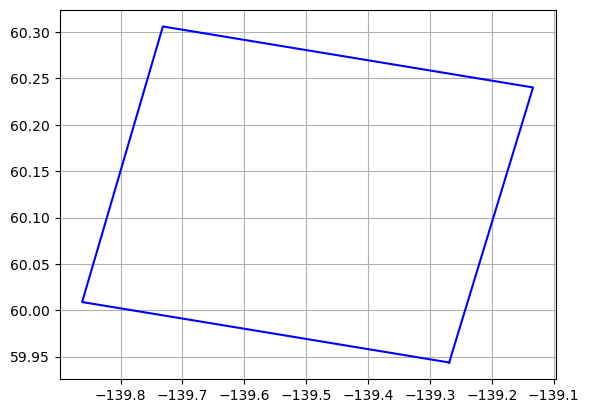

In [2]:
aoi_path = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/'
aoi_fn = 'ifsar_bounds.geojson'

poly = sliderule.toregion(os.path.join(aoi_path, aoi_fn))['poly']

# extract lat and lon coordinates
poly_lon = [x['lon'] for x in poly]
poly_lat = [x['lat'] for x in poly]
    
# plot
fig, ax = plt.subplots()
ax.plot(poly_lon, poly_lat, '-b')
ax.grid()
plt.show()

In [ ]:
# # Define path and filenames for AOI shapefile and geojsons
# aoi_path = '/Users/raineyaberle/Research/PhD/Hubbard/RGI/'
# aoi_shp_fn = 'Hubbard_boundaries.shp'
# aoi_geojson_fn = 'Hubbard_boundaries.geojson'

# # Define output path for CSVs
# csv_path = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/ICESat-2/CSVs/'

# # set up figure
# fig, ax = plt.subplots(1, 1)

# # load shapefile
# aoi_shp = gpd.read_file(os.path.join(aoi_path, aoi_shp_fn))
# aoi_shp.plot(ax=ax, facecolor='None', edgecolor='k')

# # If geojson does not exist in directory, load shapefile, buffer and simplify geometry, save to file as geojson
# if not os.path.exists(os.path.join(aoi_path, aoi_geojson_fn)):
    
#     # buffer geometry
#     aoi_shp['geometry'] = aoi_shp['geometry'][0].buffer(0.05)
    
#     # save to aoi_path as geojson
#     aoi_shp.to_file(os.path.join(aoi_path, aoi_geojson_fn), driver='GeoJSON')
#     print('geojson saved to file: ', os.path.join(aoi_path, aoi_geojson_fn))
        
# # read geojson simplified polygon
# poly = sliderule.toregion(os.path.join(aoi_path, aoi_geojson_fn))["poly"]

# # extract lat and lon coordinates
# poly_lon = [x['lon'] for x in poly]
# poly_lat = [x['lat'] for x in poly]
    
# # plot
# ax.plot(poly_lon, poly_lat, '-b')
# ax.grid()
# plt.show()


## SlideRule Product Processing

In [ ]:
# Set processing parameters
parms = {
    "poly": poly,
    "srt": icesat2.SRT_LAND,
    "len": 20,
    "cnf": icesat2.CNF_SURFACE_HIGH, 
}

### Calculate ATL06 elevations

In [ ]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
data = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Received {} elevations".format(data.shape[0]))

# Print data to check results
data

### Plot ATL06 results

In [ ]:
f, ax = plt.subplots(1, 1)
data.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1, legend=True)
ax.plot(poly_lon, poly_lat, linewidth=1, color='k')
plt.show()

### Save ATL06 data to CSVs for each separate date

In [ ]:
csv_path = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/ICESat-2/CSVs/'

dates = np.unique(pd.DatetimeIndex(data.index).date)
for date in dates:
    data_date = data.loc[pd.DatetimeIndex(data.index).date==date]
    data_fn = os.path.join(csv_path, str(date) + '_ICESat-2_ATL06_Hubbard.csv')
    data_date.to_csv(data_fn)
    print(f'{date} CSV saved to file.')